# 20152410 배형준 머신러닝 과제6

In [1]:
# library import

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# set my local working directory

import os

directory = 'C:\\Users\\golds\\Desktop\\중앙대학교\\2020-1 4학년 1학기\\머신러닝'
os.chdir(directory)

# 1. Plot the training data

In [3]:
# load dataset

train = pd.read_csv('./과제6/data-nonlinear.txt', header=None)
train.columns = ['x', 'y', 'l']

label_0 = train.loc[train['l'] == 0, :]
label_1 = train.loc[train['l'] == 1, :]

X = np.array(train[['x', 'y']])
Y = np.array(train['l']).reshape(-1, 1)

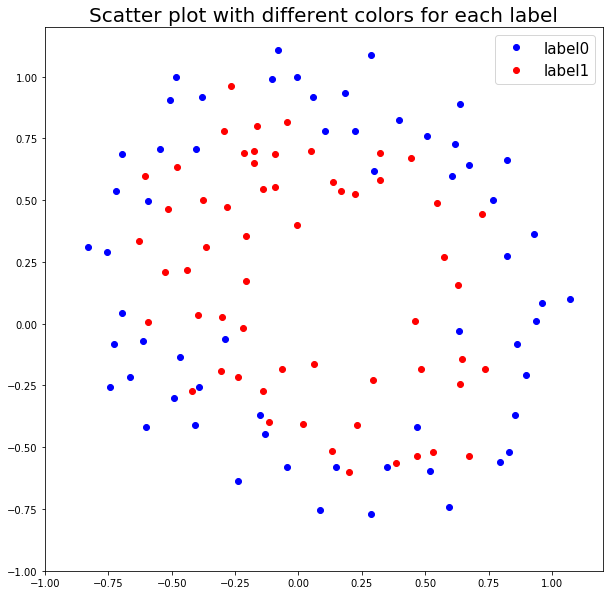

In [4]:
# scatter plot with different colors for each label

plt.figure(figsize=(10, 10))
plt.plot(label_0.x, label_0.y, 'bo', label='label0')
plt.plot(label_1.x, label_1.y, 'ro', label='label1')
plt.xlim((-1, 1.2))
plt.ylim((-1, 1.2))
plt.legend(loc='best', fontsize=15)
plt.title('Scatter plot with different colors for each label', fontsize=20)
plt.show()

직선으로는 두 집단을 명확하게 구분할 수 없는 것을 시각적으로 확인할 수 있다. 빨간색 점들을 안쪽에, 파란색 점들을 바깥쪽에 위치시킬 수 있는 적절한 구분선이 필요해보인다. 최대 16개의 변수를 사용할 수 있으므로 15개의 항이 필요한 4차 다항 로지스틱 회귀를 사용하려고 한다.

# 2. Write down the high dimensional function $g(x, y, \theta)$

$f_0(x, y) = 1$

$f_1(x, y) = x^1$

$f_2(x, y) = x^2$

$f_3(x, y) = x^3$

$f_4(x, y) = x^4$

$f_5(x, y) = y^1$

$f_6(x, y) = x^1y^1$

$f_7(x, y) = x^2y^1$

$f_8(x, y) = x^3y^1$

$f_9(x, y) = y^2$

$f_{10}(x, y) = x^1y^2$

$f_{11}(x, y) = x^2y^2$

$f_{12}(x, y) = y^3$

$f_{13}(x, y) = x^1y^3$

$f_{14}(x, y) = y^4$

$z = g(x, y, \theta) = \sum_{i=0}^{14}\theta_if_i(x, y) = \theta_0f_0(x, y) + \theta_1f_1(x, y) + \cdots + \theta_{14}f_{14}(x, y)$

$\sigma(z) = \frac{1}{1 + exp(-z)}$

## Implement polynomial logistic regression

In [5]:
# 이제까지 def로만 해봤는데 class로도 해보고 싶어서 새로운 시도를 한다!

class polynomial_logistic_regression:
    def __init__(self, learning_rate=0.01, error_bound=10**(-8), critical_value=0.5, iteration=100000, polynomial_degree=4):
        self.learning_rate = learning_rate
        self.error_bound = error_bound
        self.critical_value = critical_value
        self.iteration = iteration
        self.polynomial_degree = polynomial_degree
        
        self.coef_ = 0
        self.record_coef = 0
        self.record_cost = []
        self.record_accuracy = []
        
    def sigmoid(self, X, theta):
        z = np.dot(X, theta)
        return 1 / (1 + np.exp(-z))
    
    def cost(self, sigma, label):
        delta = 10**(-10)
        value = - np.mean(label * np.log(sigma + delta) + (1 - label) * np.log(1 - sigma + delta)) 
        return value
    
    def make_polynomial(self, X, polynomial_degree):
        X = np.array(X)
        degree = []
        for j in range(polynomial_degree+1):
            for i in range(polynomial_degree+1):
                if j + i <= polynomial_degree:
                    degree.append((i, j))
        
        name = ['x{}y{}'.format(degree[i][0], degree[i][1]) for i in range(len(degree))]
        poly = np.zeros((X.shape[0], len(degree)))
        
        for i in range(len(degree)):
            poly[:, i] = X[:, 0]**(degree[i][0]) * X[:, 1]**(degree[i][1])
        
        return pd.DataFrame(poly, columns=name)
        
    def fit(self, X, Y):
        X = np.array(self.make_polynomial(X, self.polynomial_degree))
        Y = np.array(Y).reshape(-1, 1)
        n = X.shape[0]
        p = X.shape[1]
        
        theta = np.zeros((p, 1))
        self.record_coef = theta.T
        
        sigma = self.sigmoid(X, theta)
        cost = self.cost(sigma, Y)
        self.record_cost.append(float(cost))
        
        predict = np.where(sigma >= self.critical_value, 1, 0).reshape(-1, 1)
        accuracy = np.mean(predict == Y)
        self.record_accuracy.append(accuracy)
        
        import time
        start = time.time()
        
        # model fitting
        while True:
            # calculate gradient
            gradient = np.dot(X.T, sigma - Y) / n
        
            # renew the parameters, calculate cost to evaluate the parameters
            theta = theta - self.learning_rate * gradient
            sigma = self.sigmoid(X, theta)
            cost = self.cost(sigma, Y)
        
            # store results
            self.record_coef = np.vstack((self.record_coef, theta.T))
            self.record_cost.append(float(cost))
            
            predict = np.where(sigma >= self.critical_value, 1, 0).reshape(-1, 1)
            accuracy = np.mean(predict == Y)
            self.record_accuracy.append(accuracy)

            # stopping rules
            if len(self.record_cost) > self.iteration and self.record_cost[-2] - self.record_cost[-1] < self.error_bound:
                break
            
            # print model fitting process
            if len(self.record_cost) % 20000 == 0:
                print('Running time : {}s, Iter : {}, Cost : {}'.format(round(time.time() - start), len(self.record_cost), cost))
            
            # error situation
            if len(self.record_cost) > 300000:
                print('반복 횟수가 너무 많습니다. cost가 수렴하지 않은 상태로 학습을 종료합니다. 학습률을 조정해보시기 바랍니다.')
                break
        
        self.coef_ = self.record_coef[-1, :].T
        
        return self
        
    def predict_probability(self, X):
        X = np.array(self.make_polynomial(X, self.polynomial_degree))
        return self.sigmoid(X, self.coef_).reshape(-1, 1)
    
    def predict_label(self, X):
        X = np.array(self.make_polynomial(X, self.polynomial_degree))
        value = self.sigmoid(X, self.coef_)
        predict = np.where(value >= self.critical_value, 1, 0).reshape(-1, 1)
        return predict.reshape(-1, 1)


## Model fitting

In [6]:
model = polynomial_logistic_regression(learning_rate=1,
                                       error_bound=10**(-7),
                                       critical_value=0.5,
                                       iteration=100000,
                                       polynomial_degree=4)

In [7]:
model.fit(X, Y)

Running time : 17s, Iter : 20000, Cost : 0.3265207718964538
Running time : 69s, Iter : 40000, Cost : 0.3255039619964917
Running time : 151s, Iter : 60000, Cost : 0.32500786959529443
Running time : 266s, Iter : 80000, Cost : 0.32462273581677104
Running time : 418s, Iter : 100000, Cost : 0.3242958527227771


# 3. Plot the training error

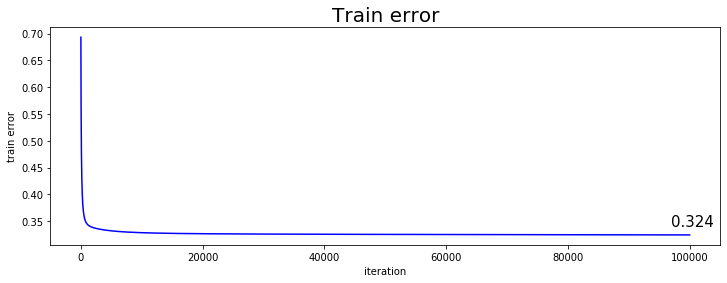

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(model.record_cost, 'b-')
plt.title('Train error', fontsize=20)
plt.xlabel('iteration')
plt.ylabel('train error')
plt.text(len(model.record_cost) - 3000, 0.34, '0.324', fontsize=15)
plt.show()

반복 수 10000회 정도를 지나서 안정적으로 수렴한 모습을 확인할 수 있다. 10000회 정도만 지나도 수렴했다고 말할 수 있지만 학습 정지 조건을

1) 최소 반복수는 100000회

2) 한 번 더 반복했을 때 cost가 $10^{-7}$ 이하로 감소

하는 것으로 설정하였기 때문에 10000회에서 멈추지 않고 학습을 이어나갔다.

# 4. Plot the training accuracy

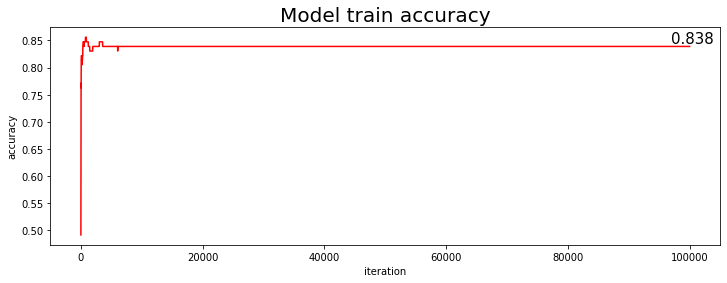

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(model.record_accuracy, 'r-')
plt.title('Model train accuracy', fontsize=20)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.text(len(model.record_accuracy) - 3000, 0.845, '0.838', fontsize=15)
plt.show()

Train error plot에 확인했듯이 반복 수가 10000회 이상 넘어가면서 accuracy가 수렴한다.

# 5. Write down the final training accuracy

In [14]:
print(' Model fitting result \n iteration : {} \n train error : {} \n train accuracy : {}%'.format(
    len(model.record_cost), round(model.record_cost[-1], 5), round(model.record_accuracy[-1], 5)*100))

 Model fitting result 
 iteration : 100001 
 train error : 0.3243 
 train accuracy : 83.898%


# 6. Plot the optimal classifier superimposed on the training data

In [11]:
# make x_grid, y_grid, z_grid

x_linspace = np.linspace(-1, 1.2, 300)
y_linspace = np.linspace(-1, 1.2, 300)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)

z_grid = np.zeros(x_grid.shape)

for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        temp = np.array([x_grid[i, j], y_grid[i, j]]).reshape(1, 2)
        temp_poly = model.make_polynomial(temp, polynomial_degree=4)
        z_grid[i, j] = model.sigmoid(temp_poly, model.coef_.reshape(-1, 1))

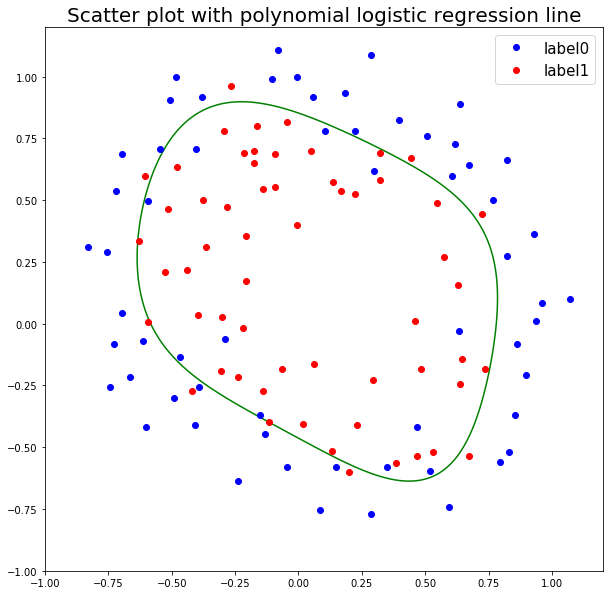

In [12]:
# scatter plot with different colors for each label

plt.figure(figsize=(10, 10))
plt.plot(label_0.x, label_0.y, 'bo', label='label0')
plt.plot(label_1.x, label_1.y, 'ro', label='label1')
plt.xlim((-1, 1.2))
plt.ylim((-1, 1.2))
plt.legend(loc='best', fontsize=15)
plt.title('Scatter plot with polynomial logistic regression line', fontsize=20)
plt.contour(x_grid,
            y_grid,
            z_grid,
            levels=[0.5],
            colors='green')
plt.show()

초록 선의 바깥쪽에 위치한 점들을 label 0 (파란색)으로 예측하고 안쪽에 위치한 점들을 label 1 (빨간색)으로 예측한다.